<a href="https://colab.research.google.com/github/adowaconan/Deep_learning_fMRI/blob/master/5_4_back_tracking_gradients_and_derive_an_encoding_model_from_the_decoding_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Just installing some of the necessary libraries to get the data and process the data

In [1]:
!pip install -U -q PyDrive
!pip install tqdm
!apt-get install swig
!pip install -U pymvpa2
!pip install -U seaborn
!pip install nilearn

# this lets you access to googel drive shared files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Reading package lists... Done
Building dependency tree       
Reading state information... Done
swig is already the newest version (3.0.12-1).
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.
Requirement already up-to-date: pymvpa2 in /usr/local/lib/python2.7/dist-packages (2.6.5)
Requirement already up-to-date: seaborn in /usr/local/lib/python2.7/dist-packages (0.9.0)


# Copying the word list and the word2vec model from Google Drive to Colab, so it will take some time.

In [0]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


word_list_id = 'https://drive.google.com/open?id=18nfVy-o0GWX-QKEWrKK0EKLLAltpFy4U'.split('id=')[-1]
word2vec_model_id = 'https://drive.google.com/open?id=1Dj9aTqHbuknWZC9kQJabqH3NqGXe_PT4'.split('id=')[-1]

word_list = drive.CreateFile({'id':word_list_id})
word2vec_model_ = drive.CreateFile({'id':word2vec_model_id})

word_list.GetContentFile('{}'.format('word.npy'))
word2vec_model_.GetContentFile('{}'.format('glove-sbwc.i25.vec'))

In [0]:
roi_id = 'https://drive.google.com/open?id=10cAoPizl69QR2RekIKpkdrv9J4_Emcq-'.split('id=')[-1]
roi = drive.CreateFile({'id':roi_id})
roi.GetContentFile('{}'.format('roi.pkl'))

In [0]:
fmri_data_id = 'https://drive.google.com/open?id=1azfJELUXpALhuqk9QjkgQxscjngt8FIK'.split('id=')[-1]
mask_id = 'https://drive.google.com/open?id=1chMTgitz5Qb9rEjGN5ZOGLJIMxbnwC8j'.split('id=')[-1]
struc_id = 'https://drive.google.com/open?id=1Ctlw4_Qw43K3KEvFDA3NhOaW-nAOBWAd'.split('id=')[-1]
functional_id = 'https://drive.google.com/open?id=1dhIqqdovNFsaVVZKJTWEOSqRBBfMlkHR'.split('id=')[-1]

fmri_data = drive.CreateFile({'id':fmri_data_id})
mask = drive.CreateFile({'id':mask_id})
struc = drive.CreateFile({'id':struc_id})
functional = drive.CreateFile({'id':functional_id})

fmri_data.GetContentFile('{}'.format('filtered_func_data.nii.gz'))
mask.GetContentFile('{}'.format('roi_4_bin.nii.gz'))
struc.GetContentFile('{}'.format('output.nii'))
functional.GetContentFile('{}'.format('example_func.nii.gz'))

# The python libraries we will need to import

1. numpy: numerical python
2. pandas: table
3. tqdm: progress bar
4. **gensim**: need for loading word2vec models
5. scipy.spatial.distance: representational dissimilarity matrix
6. MinMaxScaler: rescale features to between 0 and 1
7. LinearSVC: a selected linear classifier
8. roc_auc_score: a selected scoring method, good for balanced or unbalanced data
9. CalibratedClassifierCV: a classifier wrapper for providing probabilistic predictions
10. MultiOutputClassifier: a classifier wrapper for decoding if target is more than 1-D
11. model_selection: CV method
12. seaborn (better in 0.9.0 version): pretty plotting
13. pickle: to load the dataset (PYMVPA format) that is stored in a pickle dump file

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt
from gensim.models.keyedvectors import KeyedVectors # for loading word2vec models
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import StratifiedShuffleSplit,LeavePGroupsOut
import seaborn as sns
sns.set_style('white')
sns.set_context('poster')
import pickle

In [6]:
# candidate model
Glove_from_SBWC = 'glove-sbwc.i25.vec'
# load the stimuli table
words = np.load('word.npy')
print('loading Glove model, and it is going to take some time...')
model_glove = KeyedVectors.load_word2vec_format(Glove_from_SBWC)

loading Glove model, and it is going to take some time...


# I lost track of how many keras functions I imported, so bear with me.

In [7]:
import keras
from keras.layers                                  import Dense,Dropout,BatchNormalization
from keras.layers                                  import Input
from keras.layers                                  import Flatten,LeakyReLU,merge
from keras.layers                                  import GaussianNoise,GaussianDropout

from keras.models                                  import Model,Sequential
from keras.layers.noise                            import AlphaDropout
from keras.callbacks                               import ModelCheckpoint,TensorBoard,EarlyStopping
from keras                                         import backend as K
from keras                                         import regularizers
from keras.layers                                  import Reshape
from keras.layers                                  import Conv3DTranspose,Activation, Lambda,Multiply
from keras.layers                                  import Layer
from keras.losses                                  import mse

from mvpa2.datasets.base                           import Dataset
from mvpa2.mappers.fx                              import mean_group_sample

from sklearn.metrics                               import roc_auc_score,roc_curve
from sklearn.metrics                               import (classification_report,
                                                           matthews_corrcoef,
                                                           confusion_matrix,
                                                           f1_score,
                                                           log_loss)
from sklearn.preprocessing                         import MinMaxScaler

from sklearn.model_selection                       import StratifiedShuffleSplit,LeaveOneGroupOut
from sklearn.preprocessing                         import OneHotEncoder
from nilearn.input_data                            import NiftiMasker
from nilearn.plotting                              import plot_stat_map,plot_glass_brain

Using TensorFlow backend.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
/usr/local/lib/python2.7/dist-packages/nilearn/plotting/__init__.py:20: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/a

# Tons of helper functions, so that I don't have to repeat myself

In [0]:
def get_blocks(dataset__,label_map,key_type='labels'):
    """
    # use ids, chunks,and labels to make unique blocks of the pre-average dataset, because I don't want to 
    # average the dataset until I actually want to, but at the same time, I want to balance the data for 
    # both the training and test set.
    """
    ids                     = dataset__.sa.id.astype(int)
    chunks                  = dataset__.sa.chunks
    words                   = dataset__.sa.words
    if key_type == 'labels':
        try: # in metasema
            labels              = np.array([label_map[item] for item in dataset__.sa.targets])[:,-1]
        except:# not in metasema
            labels              = np.array([label_map[item] for item in dataset__.sa.targets])
        
    elif key_type == 'words':
        labels              = np.array([label_map[item] for item in dataset__.sa.words])
    sample_indecies         = np.arange(len(labels))
    blocks                  = [np.array([ids[ids             == target],
                                         chunks[ids          == target],
                                         words[ids           == target],
                                         labels[ids          == target],
                                         sample_indecies[ids == target]
                                         ]) for target in np.unique(ids)]
    block_labels            = np.array([np.unique(ll[-2]) for ll in blocks]).ravel()
    return blocks,block_labels

def customized_partition(dataset__,label_map):
    """
    Similar to the function above, but it nests with cross validation process,
    making sure each word instance will appear in the test set for at least once
    """
    unique_words = np.unique(dataset__.sa.words)
    unique_chunks = np.unique(dataset__.sa.chunks)
    try: # in metasema
        labels              = np.array([label_map[item] for item in dataset__.sa.targets])[:,-1]
    except:# not in metasema
        labels              = np.array([label_map[item] for item in dataset__.sa.targets])
    words = dataset__.sa.words
    chunks = dataset__.sa.chunks
    blocks,block_labels = get_blocks(dataset__,label_map,key_type='labels')
    sample_indecies         = np.arange(len(labels))
    test = []
    check = []
    for n in range(int(1e5)):
        random_chunk = np.random.choice(unique_chunks,size=1,replace=False)[0]
        working_words = words[chunks == random_chunk]
        working_block = [block for block in blocks if (int(np.unique(block[1])[0]) == random_chunk)]
        random_word = np.random.choice(working_words,size=1,replace=False)[0]
        if random_word not in check:
            for block in working_block:
                if (np.unique(block[2])[0] == random_word) and (random_word not in check):
                    test.append(block[-1].astype(int))
                    check.append(block[2][0])
#                    print(test,check)
                if len(check) == len(unique_words):
                    break
            if len(check) == len(unique_words):
                break
        if len(check) == len(unique_words):
            break
    test = np.concatenate(test,0).flatten()
    train = np.array([idx for idx in sample_indecies if (idx not in test)])
    return train,test

class stacked_perceptron(object):
    """
    to construct stacked layers of dense-batchnormaization-activation-layers
    edit: batch normalization is no used due to activation SELU
    https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9
    https://arxiv.org/pdf/1706.02515.pdf
    """
    def __init__(self,
#                 inputs,
                 hidden_units, # number of neurons of the dense layer
                 layer_func                                 = Dense,
                 beta                                       = 1, # L1 regularization value
                 lamda                                      = 1,# L2 regularization, used exclusively in parameters regularization
                 dropout_func                               = AlphaDropout,# special drop out function: https://arxiv.org/pdf/1706.02515.pdf
                 dropout_rate                               = 0.2,# dropout rate
                 name                                       = [1,1,'encode'],# the way of naming the layers
                 kernel_regularizer                         = regularizers.l1_l2,# parameter regularization function: elatic
                 kernel_initializer                         ='he_normal',# initialize the parameter method
                 activation                                 = 'selu',# self normalizing NN
                 alpha                                      = 0.3, # not used
                 l1                                         = False, # default of not using L1 activation regularization
                 use_bias                                   = True,# defult of using bias terms in the dense layers
                 batch_normal                               = True,# defult of using batch normalization
                 ):
#        self.inputs = inputs
        self.layer_func                                     = layer_func
        self.hidden_units                                   = hidden_units
        self.kernel_regularizer                             = kernel_regularizer
        self.kernel_initializer                             = kernel_initializer
        self.beta                                           = beta
        self.lamda                                          = lamda
        self.dropout_func                                   = dropout_func
        self.dropout_rate                                   = dropout_rate
        self.name                                           = name
        self.activation                                     = activation
        self.alpha                                          = alpha
        self.l1                                             = l1
        self.use_bias                                       = use_bias
        self.batch_normal                                   = batch_normal
    def __call__(self,net):
        ####################### dense layer block ###################################################
        if self.l1: # if regularize the activation output
            net = self.layer_func(units                     = self.hidden_units,
                        use_bias                            = self.use_bias,
                        kernel_initializer                  = self.kernel_initializer,
                        kernel_regularizer                  = self.kernel_regularizer(1e-6,self.lamda),
                        activity_regularizer                = regularizers.l1(self.beta),
                        name                                = 'dense_layer{}_{}_{}'.format(self.name[0],
                                                                                           self.name[1],
                                                                                           self.name[2])
                        )(net)
        else:
            net = self.layer_func(units                     = self.hidden_units,
                        use_bias                            = True,
                        kernel_initializer                  = self.kernel_initializer,
                        kernel_regularizer                  = self.kernel_regularizer(1e-6,self.lamda),
#                        activity_regularizer = regularizers.l1(self.beta),
                        name                                = 'dense_layer{}_{}_{}'.format(self.name[0],
                                                                                           self.name[1],
                                                                                           self.name[2])
                        )(net)
        #################### end of dense layer block #################################################
        #################### batch normalization block ################################################
        if self.batch_normal:
            net = BatchNormalization(name                   = 'norm_layer{}_{}_{}'.format(self.name[0],
                                                                                          self.name[1]+1,
                                                                                          self.name[2]))(net)
        ################### end of batch normalization block ################################################
        ################### actiavtion block ##########################################################
        if type(self.activation) is not str:
            net = self.activation(name                      = 'activation_layer{}_{}_{}'.format(self.name[0],
                                                                                                self.name[1]+2, 
                                                                                                self.name[2]),
                                  alpha                     = self.alpha)(net)
        else:
            net = Activation(activation = self.activation,
                             name                           = 'activation_layer{}_{}_{}'.format(self.name[0],
                                                                                                self.name[1]+2, 
                                                                                                self.name[2]),
                              )(net)
        ################### end of activation block ######################################################
        ################### dropout layer block ##########################################################
        net = self.dropout_func(rate                        = self.dropout_rate,
                      name                                  = 'drop_layer{}_{}_{}'.format(self.name[0],
                                                                                          self.name[1]+3,
                                                                                          self.name[2]))(net)
        
        return net
def make_CallBackList(model_name,monitor='val_loss',mode='min',verbose=0,min_delta=1e-4,patience=50,frequency = 1):
    """
    Make call back function lists for the keras models
    
    Inputs
    -------------------------
    model_name: directory of where we want to save the model and its name
    monitor: the criterion we used for saving or stopping the model
    mode: min --> lower the better, max --> higher the better
    verboser: printout the monitoring messages
    min_delta: minimum change for early stopping
    patience: temporal windows of the minimum change monitoring
    frequency: temporal window steps of the minimum change monitoring
    
    Return
    --------------------------
    CheckPoint: saving the best model
    EarlyStopping: early stoppi....
    """
    checkPoint = ModelCheckpoint(model_name,# saving path
                                 monitor          =monitor,# saving criterion
                                 save_best_only   =True,# save only the best model
                                 mode             =mode,# saving criterion
                                 period           =frequency,# frequency of check the update 
                                 verbose          =verbose# print out (>1) or not (0)
                                 )
    earlyStop = EarlyStopping(   monitor          =monitor,
                                 min_delta        =min_delta,
                                 patience         =patience,
                                 verbose          =verbose, 
                                 mode             =mode,
                                 )
    return [checkPoint,earlyStop]
def clf(shape = 2000,
         beta               = 1,
         lamda              = 1,
         dropout_rate       = 0.,
         latent_dim         = 36,
         lr                 = 1e-3,
         decay              = 0,
         add_noise          = False,
         add_sparsity       = False,
         rho                = 0.02,
         sparse_beta        = 1,
         output_shape       = 2,
         gen_shape_input    = 300,
         gen_shape_output   = 2000,
         ):
    """
    This function generates a simple DNN classifier with at least 3 layers:
    1. input layer
    2. hidden layer (feature wrapper)
    3. output layer (prediction decision making function)
    """
    inputs                  = Input(shape                                   = (shape,),
                              batch_shape                                   = (None,shape),
                              name                                          = 'inputs',
                              dtype                                         = 'float32'
                              )
    gen_inputs              = Input(shape                                   = (gen_shape_input,),
                              batch_shape                                   = (None,gen_shape_input),
                              name                                          = 'gen_inputs',
                              dtype                                         = 'float32'
                              )
    ####################################### add noise to the inputs #################################
    ############################ Gaussian noise #####################################################
    if add_noise:
        inputs_            = GaussianNoise(stddev = 1)(inputs)
        encode_            = inputs_
    else:
        encode_            = inputs
    if type(latent_dim) is int:
        latent_dims = [latent_dim]
    else:
        latent_dims = latent_dim
    for jj,latent_dim_ in enumerate(latent_dims):
        np.random.seed(12345)
        encode_           = stacked_perceptron(latent_dim_,
                                              beta                          = beta,
                                              lamda                         = lamda,
                                              dropout_rate                  = dropout_rate,
                                              name                          = [jj+1,jj+1,'latent'],
                                              use_bias                      = True,
                                              batch_normal                  = True,
                                              activation                    = 'sigmoid',
                                              )(encode_)
        if add_sparsity:
            encode_       = _sparse_reg(rho = rho, beta = sparse_beta)(encode_)
    decode_                = encode_
    np.random.seed(12345)
    outputs                = Dense(units                                    = output_shape,
                             use_bias                                       = True,
                             name                                           ='outputs',
                             kernel_initializer                             = 'he_normal',
                             kernel_regularizer                             = regularizers.l1_l2(beta,lamda),
                             activity_regularizer                           = regularizers.l1(1),
                             activation                                     = 'softmax',# constraint between 0 and 1
                             )(decode_)
    model                  = Model(inputs, outputs, name = 'classifier')
    model.compile(optimizer= keras.optimizers.Adam(lr = lr,decay = decay),
                  loss     = keras.losses.categorical_crossentropy,
                  metrics  = [keras.metrics.categorical_accuracy]
                  )
    # generator
    gen_inputs_        = GaussianNoise(stddev = 1)(gen_inputs)
    gen_encode_        = gen_inputs_
    for jj,latent_dim in enumerate(latent_dims):
        np.random.seed(12345)
        gen_encode_ = stacked_perceptron(latent_dim_,
                                              beta                          = beta,
                                              lamda                         = lamda,
                                              dropout_rate                  = dropout_rate,
                                              name                          = [jj+1,jj+1,'latent_gen'],
                                              use_bias                      = True,
                                              batch_normal                  = True,
                                              activation                    = 'sigmoid',
                                              )(gen_encode_)
    gen_decode_ = gen_encode_
    np.random.seed(12345)
    gen_outputs                = Dense(units                                    = gen_shape_output,
                             use_bias                                       = True,
                             name                                           ='outputs_gen',
                             kernel_initializer                             = 'he_normal',
                             kernel_regularizer                             = regularizers.l1_l2(beta,lamda),
                             activity_regularizer                           = regularizers.l1(beta),
                             activation                                     = 'sigmoid',# constraint between 0 and 1
                             )(gen_decode_)
    generator = Model(gen_inputs,gen_outputs,name='generator')

    # full model
    generator_inputs_outputs = model(generator(gen_inputs))
    full_model = Model(gen_inputs,generator_inputs_outputs)
    full_model.compile(optimizer= keras.optimizers.Adam(lr = lr,decay = decay),
                  loss     = keras.losses.categorical_crossentropy,
                  metrics  = [keras.metrics.categorical_accuracy]
                  )
    
    return model,generator,full_model



In [9]:
model,gnerator,full_model = clf()

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
full_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gen_inputs (InputLayer)      (None, 300)               0         
_________________________________________________________________
generator (Model)            (None, 2000)              84980     
_________________________________________________________________
classifier (Model)           (None, 2)                 72254     
Total params: 157,234
Trainable params: 157,090
Non-trainable params: 144
_________________________________________________________________


# These are the so-called hyperparameters of the model

1. sub
2. average: if True, average across volumes that correspond to the same instance of stimulus
3. transfer: 
4. concatenate:
5. flip: a way to increase training data
6. n_splits: times of cross validation in the train-validate process (training only)
7. test_size: proportion of train-test partitioning
8. patience: after training for a while, the accuracy/loss of the validation data does not change, this defines how many epochs waited before moving on to the next train-validate partition
9. epochs: just a huge number
10. print_train: debugging argument
11. batch_size: smaller the better training but also time consuming
12. beta: L1 regularization term, to zero out some of the weights
13. lamda: L2 regularization term, to minimize the sum of all weights
14. learning_rate: training step size
15. decay: scheduled learning rate decrease
16. dropout_rate: randomly deactivate a proportion of the neurons in the network during training
17. latent_dim: latent dimension, can be a list of an integer

In [0]:
label_map               = dict(animal  =[0,1],
                               tool    =[1,0])
sub                     = '*'       # star means all subjects
average                 = False      # averaging the trainig data
transfer                = False     # do I do domain adaptation
concatenate             = False     # specifically for domain adaptation
flip                    = True,     # double the size of the training data
n_splits                = 10        # number of cross validation
test_size               = 0.2       # proprotion of the test data
patience                = 70 # if after this many epochs, the loss or the accuracy does not change, we stop the training
epochs                  = 3000 # just use a large number to prompt early stop
print_train             = 0 # 1 - print the progress bar, 0 - don't
batch_size              = 64
beta                    = 0.
lamda                   = 0.
learning_rate           = 1e-4
decay                   = 1e-9
dropout_rate            = 0.5
latent_dim              = 36

# load the data and select "read" condition

In [0]:
ds = pickle.load(open('roi.pkl','rb'))

In [0]:
condition = 'read'

# As this is just a demonstration, I will perform only one cross-validation

In [0]:
dataset_ = ds[ds.sa.context == condition]

cv = LeaveOneGroupOut()
chunks = dataset_.sa.chunks

for train,test in cv.split(dataset_.samples,dataset_.sa.targets,chunks):
    train,test

dataset = dataset_[train]
dataset_test = dataset_[test].get_mapped(mean_group_sample(['chunks', 'id'],order = 'occurrence'))

# Train the model with the training data. The training data will further split to training and validating data

In [15]:
np.random.seed(12345)
output_dir = ''
sub_name = 'test'
roi_name = 'roi'
# must do!!! Otherwise, it will run out of resource eventualy
K.clear_session()

X_train = dataset.samples.astype('float32')
groups = dataset.sa.chunks

y_train = np.array([label_map[item] for item in dataset.sa.targets])


# define the scaler
scaler          = MinMaxScaler() # scale the data between 0 and 1
X_train = scaler.fit_transform(X_train)
shape       = dataset.shape[1]
dnn_model_name   = 'temp.hdf5'
# control the initialization of the DNN model
np.random.seed(12345)
classifier,generator,full_model= clf(
                          shape, # input shape
                          dropout_rate          = dropout_rate, # drop out rate for each hidden layer
                          beta                  = beta, # for sparsity
                          lamda                 = lamda, # for model simplicity
                          lr                    = learning_rate, # learning rate
                          decay                 = decay, # schedule decay of the learning rate 
                          latent_dim            = latent_dim, # latent space dimensionality 
                          gen_shape_input    = 300,
                          gen_shape_output   = shape,
                          )
generator.trainable = False # freeze the generator in training
# we will need 2 call back functions: 1) in-train saving and 2) early stopping
callBackList = make_CallBackList(dnn_model_name,
                               monitor                      = 'val_{}'.format(classifier.metrics_names[-1]), # metric I care
                               mode                         = 'max', # how I care
                               verbose                      = 0,# print out the process
                               min_delta                    = 1e-5,# how much difference it should make
                               patience                     = patience, # early stop argument
                               frequency                    = 1
                               )
blocks_tr,block_labels    = get_blocks(dataset,label_map)
cv = StratifiedShuffleSplit(n_splits=n_splits,test_size=.2,random_state=12345)
iterator = cv.split(blocks_tr,block_labels)
for z,(training,validation) in enumerate(iterator):
    idx_training    = np.concatenate([blocks_tr[tr_el][-1] for tr_el in training]).astype(int)
    idx_validation  = np.concatenate([blocks_tr[te_el][-1] for te_el in validation]).astype(int)
    print('{} loss starts with {:.4f} on source'.format('DNN',
                                classifier.evaluate(
                                                  X_train,
                                                  y_train,
                                                  batch_size                    = batch_size,
                                                  verbose                       = 0
                                                                          )[0]))
    from sklearn import utils as sk_utils
    X,y = sk_utils.shuffle(X_train[idx_training],y_train[idx_training])
    history                 = classifier.fit(  
                                    X,y,# input, output
                                    batch_size                              = batch_size,# min batch size
                                    epochs                                  = epochs,# just lots of epochs
                                    validation_data                         = (X_train[idx_validation],y_train[idx_validation]),# split the last 10% of the data as the validation data
                                    verbose                                 = print_train,# print out the process
                                    callbacks                               = callBackList # call back functions
                                    )

    classifier.load_weights(dnn_model_name) # load the saved best model weights
    # let's look at the current model loss with all the training + validation data combined
    training_loss = classifier.evaluate(X_train,y_train,
                                         batch_size                     = batch_size,
                                         verbose                        = 0
                                         )
    print('{} current loss = {:.4f},{} = {:.4f} on source'.format(
          'DNN',
          training_loss[0],
          classifier.metrics_names[-1],
          training_loss[-1]))
    
classifier.load_weights(dnn_model_name)

DNN loss starts with 64.2018 on source
Instructions for updating:
Use tf.cast instead.
DNN current loss = 63.7291,categorical_accuracy = 0.8343 on source
DNN loss starts with 63.7291 on source
DNN current loss = 63.6906,categorical_accuracy = 0.8676 on source
DNN loss starts with 63.6906 on source
DNN current loss = 63.6833,categorical_accuracy = 0.8752 on source
DNN loss starts with 63.6833 on source
DNN current loss = 63.6835,categorical_accuracy = 0.8691 on source
DNN loss starts with 63.6835 on source
DNN current loss = 63.6835,categorical_accuracy = 0.8691 on source
DNN loss starts with 63.6835 on source
DNN current loss = 63.6835,categorical_accuracy = 0.8691 on source
DNN loss starts with 63.6835 on source
DNN current loss = 63.6835,categorical_accuracy = 0.8691 on source
DNN loss starts with 63.6835 on source
DNN current loss = 63.6835,categorical_accuracy = 0.8691 on source
DNN loss starts with 63.6835 on source
DNN current loss = 63.6835,categorical_accuracy = 0.8691 on sourc

# Access to the training score

In [0]:
preds = classifier.predict(X_train)

In [17]:
roc_auc_score(y_train,preds)

0.9331992053028638

# Access to the testing score

In [18]:
preds = classifier.predict(scaler.transform(dataset_test.samples.astype('float32')))
roc_auc_score(np.array([label_map[item] for item in dataset_test.sa.targets]),
              preds)

0.44753086419753085

# We can see the testing score is not good, but I will demonstrate this is because the difference between the training distribution and the testing distribution

In [19]:
from scipy import stats

stats.ks_2samp(X_train.flatten(),scaler.transform(dataset_test.samples.astype('float32')).flatten())

Ks_2sampResult(statistic=0.11490099796568293, pvalue=0.0)

# Let's make 2 functions:

## 1. the feature selector: the input to hidden layer part of the trained neural network
## 2. the classifier: the very last layer of the trained neural network

In [0]:
feature_selector    = K.function([classifier.layers[0].input],
                                 [classifier.layers[-2].output])
decision_function = K.function([classifier.layers[-2].input],
                               [classifier.layers[-1].output])

In [0]:
from math import pi

# Let's plot the hidden layer in a circle. Just a reminder, we defined the hidden layer to have 36 neurons is based on the fact that we have 36 unique words used in the experiment

In [22]:
dataset_average = dataset.get_mapped(mean_group_sample(['chunks', 'id'],order = 'occurrence'))
X = dataset_average.samples.astype('float32')
y = np.array([label_map[item] for item in dataset_average.sa.targets])

 * Please note: warnings are printed only once, but underlying problem might occur many times *


# First, we plot the learned hidden representations of the training data

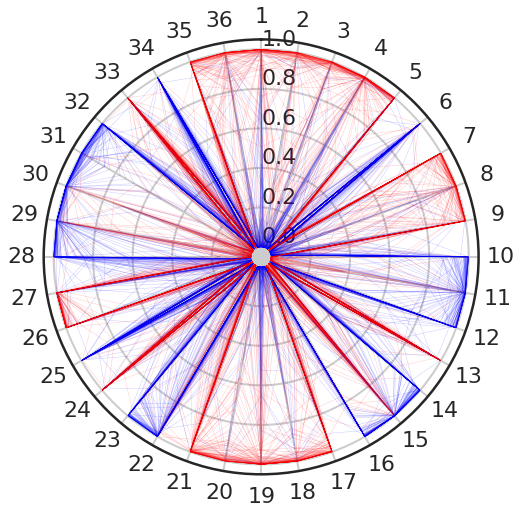

In [23]:
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw = dict(polar = True) # this enables circle plotting
                     )
latent_space        = feature_selector([X])[0]
N                   = latent_dim
angles              = [n / float(N) * 2. * pi for n in range(N)]
angles              += angles[:1]
colors              = ['red','blue'] # red = tool, blue = animal
_                   = ax.set_theta_offset(pi / 2)
_                   = ax.set_theta_direction(-1)

_                   = ax.set(xticks = angles[:-1],xticklabels=['{}'.format(n+1) for n in range(N)])

ax.set_rlabel_position(0)
for row,label in zip(latent_space,y[:,-1]):
    values          = list(row)
    values          += values[:1]
    ax.plot(angles,values,linewidth=0.5,alpha=0.2,color=colors[int(label)])

# And then, we plot the inferred hidden representations of the testing data

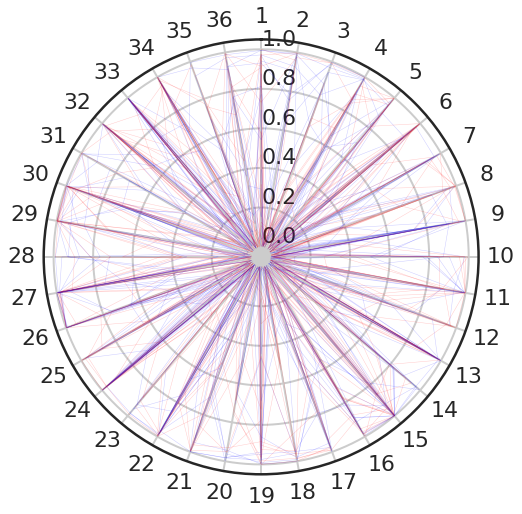

In [24]:
X = dataset_test.samples.astype('float32')
y = np.array([label_map[item] for item in dataset_test.sa.targets])
fig,ax = plt.subplots(figsize=(8,8),
                      subplot_kw = dict(polar = True) # this enables circle plotting
                     )
latent_space        = feature_selector([X])[0]
N                   = latent_dim
angles              = [n / float(N) * 2. * pi for n in range(N)]
angles              += angles[:1]
colors              = ['red','blue'] # red = tool, blue = animal
_                   = ax.set_theta_offset(pi / 2)
_                   = ax.set_theta_direction(-1)

_                   = ax.set(xticks = angles[:-1],xticklabels=['{}'.format(n+1) for n in range(N)])

ax.set_rlabel_position(0)
for row,label in zip(latent_space,y[:,-1]):
    values          = list(row)
    values          += values[:1]
    ax.plot(angles,values,linewidth=0.5,alpha=0.2,color=colors[int(label)])

# The figure above looks good, doesn't it? But does it mean some of neurons in the latent space specify in encoding one of the two classes? In other words, is some of the neurons more sensitive to one class than the other?

# One way to test this hypothese is to use some thing called the "impulse vector". An impulse vector is a 1-D vector that has "1" in one place and the rest are all zeros
## By feeding different impulse vectors to the latent layer and record the decisions made (predictions), we are able to identify how each hidden neuron contribute to the decision making.
### And we can ensemble these group of neurons to form 2 input vectors, one has "1" in the place where are sensitive to living thing class while the other one is the opposite. 
### We expect the training process allows the DNN model to uniformly use the neurons, so that half of them encode living class while the other half encode nonliving class.

In [0]:
from scipy.signal import unit_impulse

In [0]:
temp = []
for ii in range(latent_dim):
    target = unit_impulse(latent_dim,ii)
    pred_ = decision_function([target.reshape(1,-1)])[0]
    temp.append(np.argmax(pred_))

target0 = 1 - np.array(temp)
target1 = np.array(temp)

pred0 = decision_function([target0.reshape(1,-1)])[0][0][0]
pred1 = decision_function([target1.reshape(1,-1)])[0][0][1]

In [27]:
print('tool neurons:',np.where(target0 == 1),'confidence:',pred0)
print('animal neurons:',np.where(target1 == 1),'confidence:',pred1)

('tool neurons:', (array([ 0,  1,  2,  3,  4,  6,  7, 12, 16, 17, 18, 20, 23, 25, 34]),), 'confidence:', 0.98404896)
('animal neurons:', (array([ 5,  8,  9, 10, 11, 13, 14, 15, 19, 21, 22, 24, 26, 27, 28, 29, 30,
       31, 32, 33, 35]),), 'confidence:', 0.95809734)


Apparently, the hidden layer of the classifier split the neurons to encode the classes. If we only activate those neuron and silent the those, the decision function will product high confidence prediction. 

# How would this help us to understand the brain? One of the ways is to track back to the input layer and see what kind of input (BOLD signal) would maximize the activation of the animal neurons and the tool neurons correspondently.



In [28]:
import tensorflow as tf

output = classifier.layers[-2].output
loss = K.categorical_crossentropy(tf.convert_to_tensor(target0.astype('float32')),output)
grads = K.gradients(loss, classifier.layers[0].get_input_at(0))[0]
grads = K.l2_normalize(grads)
func = K.function([classifier.layers[0].get_input_at(0)], [loss, grads])

lr = 1e-3  # learning rate used for gradient updates
max_iter = 1000  # number of gradient updates iterations
input_voxels = np.ones((1,shape)) * 0.5
for i in range(max_iter):
    loss_val, grads_val = func([input_voxels])
    input_voxels -= grads_val * lr  # update the image based on gradients
print(np.vstack([target0,feature_selector([input_voxels])[0]]).T)

[[1.         0.96221173]
 [1.         0.872944  ]
 [1.         0.89093006]
 [1.         0.90374732]
 [1.         0.8680132 ]
 [0.         0.05498567]
 [1.         0.88486433]
 [1.         0.94807649]
 [0.         0.66650945]
 [0.         0.07887211]
 [0.         0.05218685]
 [0.         0.01951653]
 [1.         0.97987837]
 [0.         0.06133339]
 [0.         0.03256026]
 [0.         0.03669295]
 [1.         0.92949742]
 [1.         0.91208446]
 [1.         0.93796456]
 [0.         0.76287591]
 [1.         0.95396376]
 [0.         0.06502509]
 [0.         0.03461   ]
 [1.         0.91843367]
 [0.         0.05083194]
 [1.         0.89107597]
 [0.         0.57710934]
 [0.         0.04515988]
 [0.         0.02785492]
 [0.         0.07952908]
 [0.         0.0671488 ]
 [0.         0.05071688]
 [0.         0.65579617]
 [0.         0.08487749]
 [1.         0.92776954]
 [0.         0.61978918]]


In [29]:
fmri_dir = 'filtered_func_data.nii.gz'
mask_dir = 'roi_4_bin.nii.gz'
struc_dir = 'output.nii'
functional_dir = 'example_func.nii.gz'
masker = NiftiMasker(mask_img=mask_dir,standardize=True)
masker.fit()
fmri_masked = masker.transform(fmri_dir)


/usr/local/lib/python2.7/dist-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


In [0]:
x_ = scaler.inverse_transform(input_voxels)
values_img = masker.inverse_transform(x_)

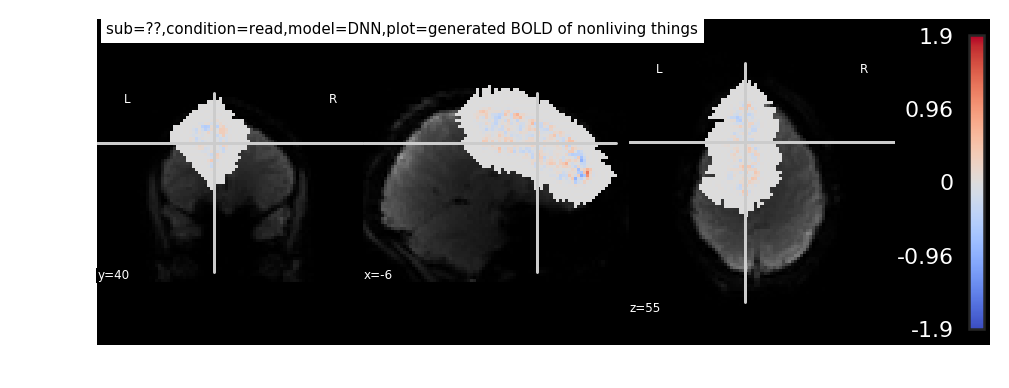

In [31]:
fig,ax = plt.subplots(figsize=(16,6))
plot_stat_map(values_img, 
              bg_img=functional_dir,
              title="sub={},condition={},model={},plot={}".format(
                      '??',
                      condition,
                      'DNN',
                      'generated BOLD of nonliving things'),
              figure=fig,
              axes=ax,
              black_bg=True,
              colorbar=True,
              cmap='coolwarm',
              threshold='auto',)

As shown above, this is what the neural network thinks how the BOLD signals should have looked like if the presented word was nonliving things. We can see that most of the voxels are zeros but there are some sparse activations, shown in blue (deactivated) and in red (activated)

# neural network problem requires neural network solutions

# Here comes the word2vec

## Here I first search for 10 words that are close to a given word from the list of words used in the experiment, and then I transform all these 11 words to vectors, but I save the 10 similar words as group and leave the one that we used in the experiment as another group.



## I will train a generator that maps the word2vec features to simulate BOLD signals (what would the BOLD look like if we present different words) and regularize the generator by the classifier we trained above. 



## The idea is similar to generative adversarial network (GAN), which concatenates a generator with a classifier, but the simplest GAN does not provide context to the generator. 

## Here, I freeze the classifier so that it would not change during the training, but use it to tell the generator to generate BOLD signals that would provide high confidence of prediction in the classifier.

## In other words, I want the generator to generate BOLD signals for the unseen words, and these BOLD signals can be easily classified by the classifier. 

In [32]:
word_labels = np.concatenate([np.ones(latent_dim/2),np.zeros(latent_dim/2)])
features_st = []
labels_st = []
for word,label_ in zip(words,word_labels):
    #print(word)
    #print(model_glove.similar_by_word(word,))
    similar = model_glove.similar_by_word(word,)
    #features.append(model_glove[word])
    #labels.append(label_)
    for word,_ in similar:
        features_st.append(model_glove[word])
        labels_st.append(label_)

features_st = np.array(features_st)
labels_st = np.array(labels_st)
labels_st = np.vstack([labels_st,1 - labels_st]).T

features = []
labels = []
for word,label_ in zip(words,word_labels):
    print(word)
    features.append(model_glove[word])
    labels.append(label_)
features, labels = np.array(features),np.array(labels)
labels = np.vstack([labels,1 - labels]).T

/usr/local/lib/python2.7/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


llave
lapiz
tijera
aguja
pinza
sierra
clavo
pincel
alicate
tuerca
navaja
cepillo
taladro
soplete
tornillo
cuchara
martillo
cuchillo
tigre
gallo
perro
oveja
cerdo
gorila
burro
yegua
ardilla
conejo
gallina
caballo
ballena
pantera
camello
tortuga
elefante
canguro


In [33]:
features.shape,labels.shape

((36, 300), (36, 2))

## Train the full model

In [34]:
# freeze the classifier
classifier.trainable = False
# unfreeze the generator
generator.trainable = True

X,y = sk_utils.shuffle(features_st,labels_st)
callBackList = make_CallBackList('generator.hdf5',
                               monitor                      = 'val_{}'.format(full_model.metrics_names[-1]), # metric I care
                               mode                         = 'max', # how I care
                               verbose                      = 0,# print out the process
                               min_delta                    = 1e-5,# how much difference it should make
                               patience                     = patience, # early stop argument
                               frequency                    = 1
                               )
cv = StratifiedShuffleSplit(n_splits=n_splits,test_size=.2,random_state=12345)
iterator = cv.split(X,y)
for z,(training,validation) in enumerate(iterator):
    from sklearn import utils as sk_utils
    X_train,y_train = sk_utils.shuffle(X[training],y[training])
    print('{} loss starts with {:.4f} on source'.format('DNN',
                                full_model.evaluate(
                                                  X_train,y_train,
                                                  batch_size                    = batch_size,
                                                  verbose                       = 0
                                                                          )[0]))
    
    history                 = full_model.fit(  
                                    X_train,y_train,# input, output
                                    batch_size                              = batch_size,# min batch size
                                    epochs                                  = epochs,# just lots of epochs
                                    validation_data                         = (X[validation],y[validation]),# split the last 10% of the data as the validation data
                                    verbose                                 = print_train,# print out the process
                                    callbacks                               = callBackList # call back functions
                                    )

    full_model.load_weights('generator.hdf5') # load the saved best model weights
    # let's look at the current model loss with all the training + validation data combined
    training_loss = full_model.evaluate(X,y,
                                         batch_size                     = batch_size,
                                         verbose                        = 0
                                         )
    print('{} current loss = {:.4f},{} = {:.4f} on source'.format(
          'full model',
          training_loss[0],
          full_model.metrics_names[-1],
          training_loss[-1]))
    


DNN loss starts with 61.1837 on source


/usr/local/lib/python2.7/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


full model current loss = 62.0339,categorical_accuracy = 0.4528 on source
DNN loss starts with 61.1442 on source
full model current loss = 61.9937,categorical_accuracy = 0.7083 on source
DNN loss starts with 61.1059 on source
full model current loss = 61.9626,categorical_accuracy = 0.8528 on source
DNN loss starts with 61.0755 on source
full model current loss = 61.8757,categorical_accuracy = 0.9389 on source
DNN loss starts with 60.9858 on source
full model current loss = 61.8757,categorical_accuracy = 0.9389 on source
DNN loss starts with 60.9854 on source
full model current loss = 61.8757,categorical_accuracy = 0.9389 on source
DNN loss starts with 60.9870 on source
full model current loss = 61.8757,categorical_accuracy = 0.9389 on source
DNN loss starts with 60.9859 on source
full model current loss = 61.8757,categorical_accuracy = 0.9389 on source
DNN loss starts with 60.9818 on source
full model current loss = 61.8757,categorical_accuracy = 0.9389 on source
DNN loss starts with 6

# Model comparison

## It is important to point out that we must substract the mean of the features of each instance before we compute the representational dissimilarity matrix

## BOLD signals from the experiment

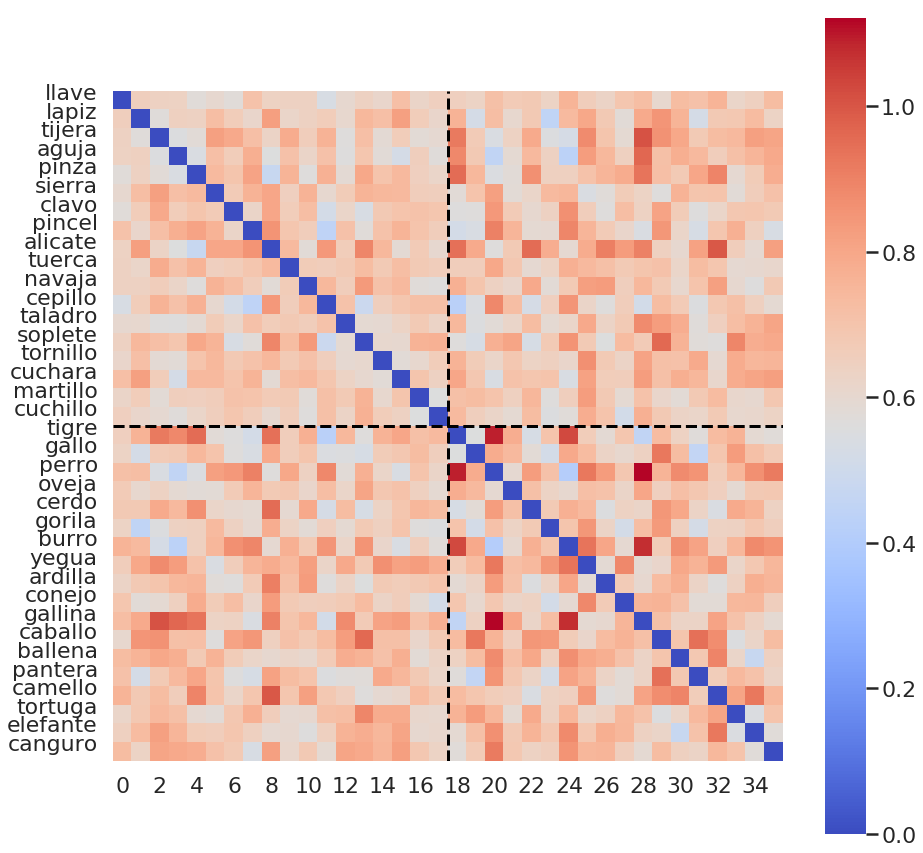

In [41]:
BOLD_dict = {word:[] for word in words}
data_array = dataset_average.samples.astype('float32')
data_array = MinMaxScaler().fit_transform(data_array)
for data,word in zip(data_array,dataset_average.sa.words):
    BOLD_dict[word.lower()].append(data)
BOLD_true = np.array([np.mean(BOLD_dict[word],0) for word in words])
BOLD_true = BOLD_true - BOLD_true.mean(1)[:,np.newaxis]
RDM = distance.squareform(distance.pdist(BOLD_true,'cosine'))
fig,ax = plt.subplots(figsize=(15,15))

im = sns.heatmap(RDM,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.axhline(RDM.shape[0]/2,linestyle='--',color='black')
ax.axvline(RDM.shape[1]/2,linestyle='--',color='black')
_=ax.set(yticks=np.arange(36),yticklabels=words)

# Latent representation (train data, aka the first 3 block of the scanning) of the classifier

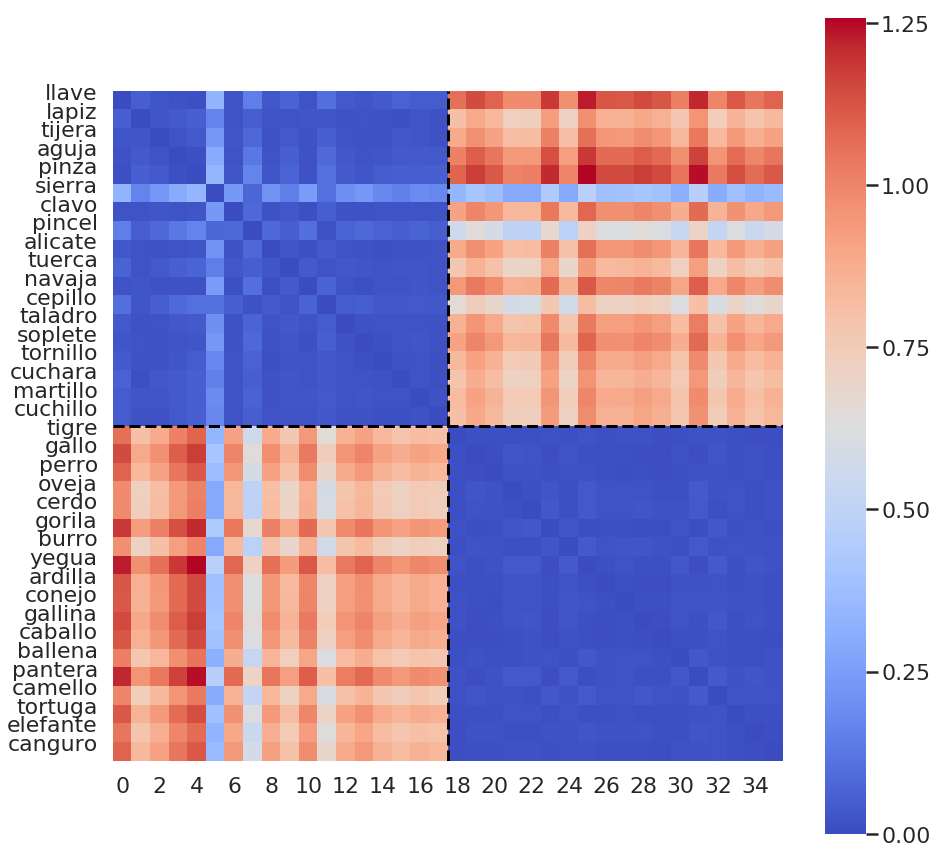

In [50]:
hidden_dict = {word:[] for word in words}
data_array = dataset.samples.astype('float32')
data_array = MinMaxScaler().fit_transform(data_array)
for data,word in zip(data_array,dataset.sa.words):
    hidden_dict[word.lower()].append(feature_selector([data.reshape(1,-1)])[0])
hidden_true = np.array([np.mean(hidden_dict[word],0) for word in words])
hidden_true = hidden_true.reshape(36,36) - hidden_true.reshape(36,36).mean(1)[:,np.newaxis]
RDM = distance.squareform(distance.pdist(hidden_true,'cosine'))
fig,ax = plt.subplots(figsize=(15,15))

im = sns.heatmap(RDM,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.axhline(RDM.shape[0]/2,linestyle='--',color='black')
ax.axvline(RDM.shape[1]/2,linestyle='--',color='black')
_=ax.set(yticks=np.arange(36),yticklabels=words)

## Latent representation (test data, aka the last block of the scanning) of the classifier

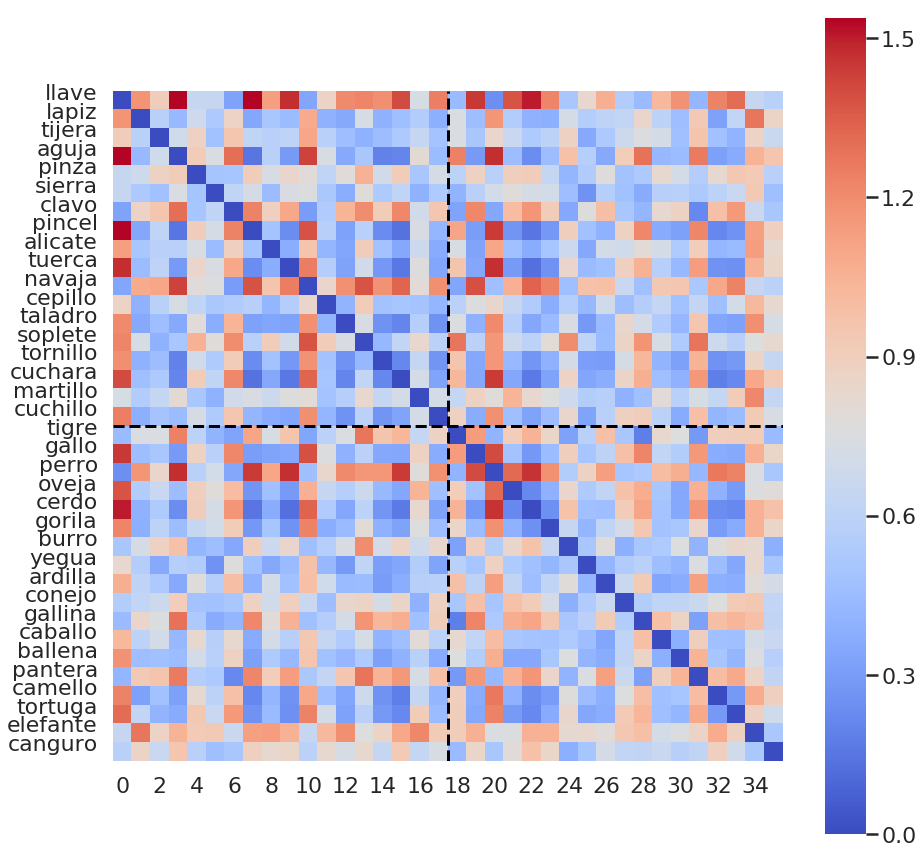

In [51]:
hidden_dict = {word:[] for word in words}
data_array = dataset_test.samples.astype('float32')
data_array = MinMaxScaler().fit_transform(data_array)
for data,word in zip(data_array,dataset_test.sa.words):
    hidden_dict[word.lower()].append(feature_selector([data.reshape(1,-1)])[0])
hidden_true = np.array([np.mean(hidden_dict[word],0) for word in words])
hidden_true = hidden_true.reshape(36,36) - hidden_true.reshape(36,36).mean(1)[:,np.newaxis]
RDM = distance.squareform(distance.pdist(hidden_true,'cosine'))
fig,ax = plt.subplots(figsize=(15,15))

im = sns.heatmap(RDM,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.axhline(RDM.shape[0]/2,linestyle='--',color='black')
ax.axvline(RDM.shape[1]/2,linestyle='--',color='black')
_=ax.set(yticks=np.arange(36),yticklabels=words)

# PCA of 36 components of the training data

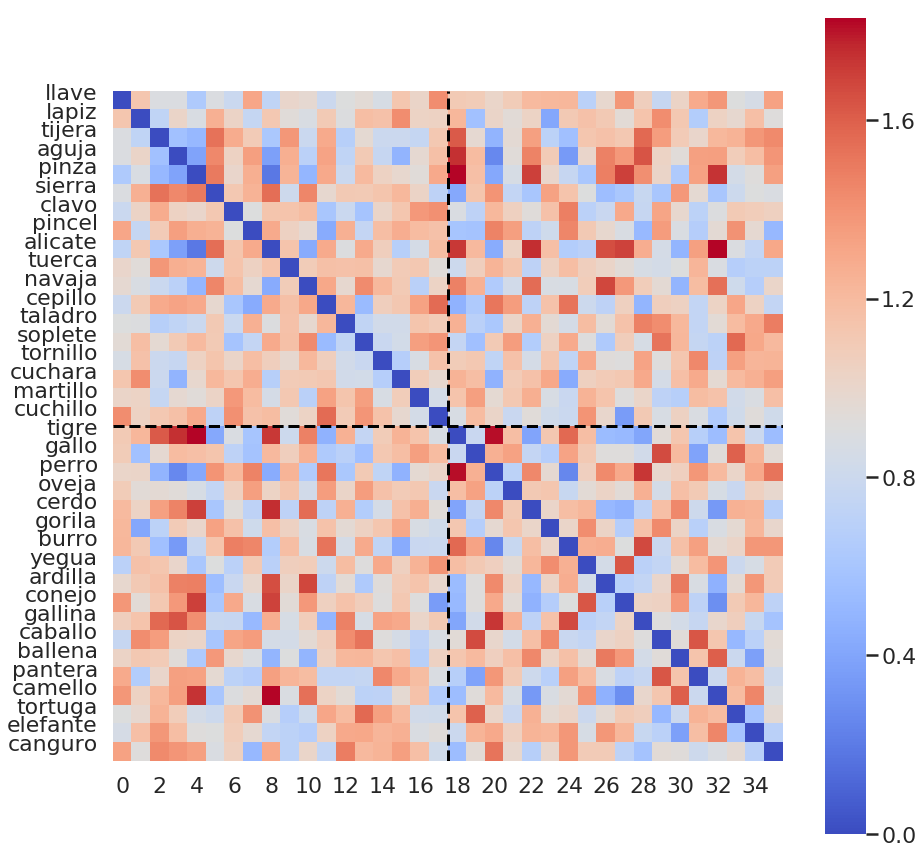

In [52]:
from sklearn.decomposition import PCA
BOLD_dict = {word:[] for word in words}
scaler = MinMaxScaler()
pca = PCA(n_components = 36)
pca.fit(scaler.fit_transform(dataset.samples.astype('float32')))
data_array = pca.transform(scaler.transform(dataset.samples.astype('float32')))
for data,word in zip(data_array,dataset.sa.words):
    BOLD_dict[word.lower()].append(data)
BOLD_true = np.array([np.mean(BOLD_dict[word],0) for word in words])
BOLD_true = BOLD_true - BOLD_true.mean(1)[:,np.newaxis]
RDM = distance.squareform(distance.pdist(BOLD_true,'cosine'))
fig,ax = plt.subplots(figsize=(15,15))

im = sns.heatmap(RDM,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.axhline(RDM.shape[0]/2,linestyle='--',color='black')
ax.axvline(RDM.shape[1]/2,linestyle='--',color='black')
_=ax.set(yticks=np.arange(36),yticklabels=words)

# PCA first 36 components of the test data

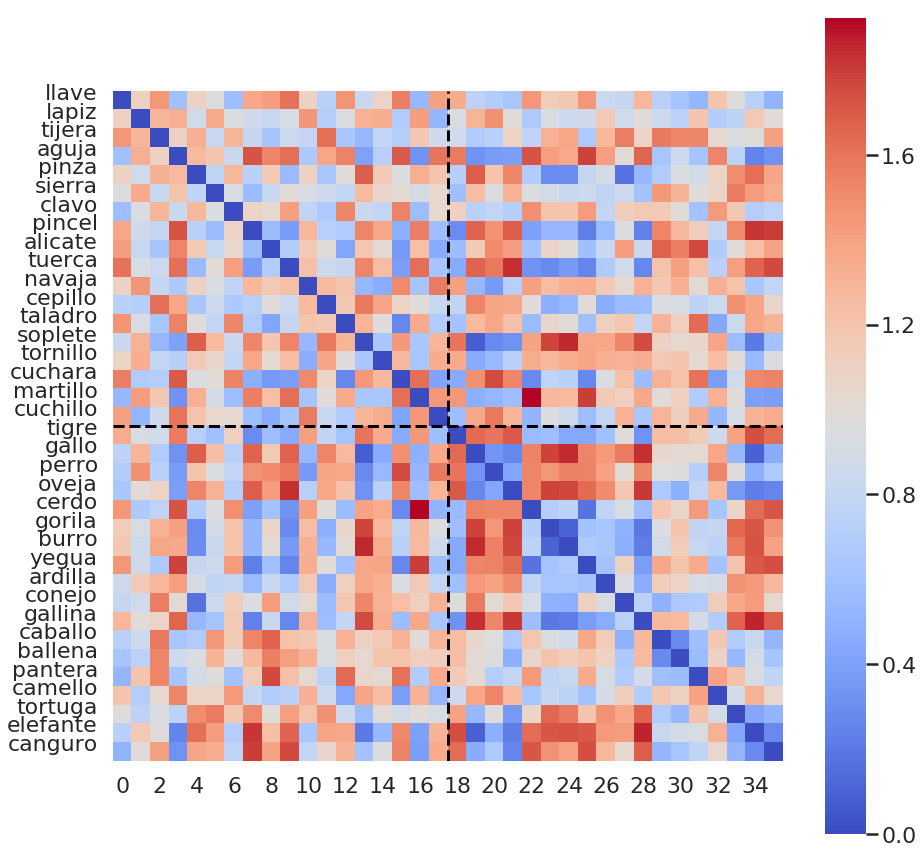

In [53]:
from sklearn.decomposition import PCA
BOLD_dict = {word:[] for word in words}
scaler = MinMaxScaler()
pca = PCA(n_components = 36)
pca.fit(scaler.fit_transform(dataset.samples.astype('float32')))
data_array = pca.transform(scaler.transform(dataset_test.samples.astype('float32')))
for data,word in zip(data_array,dataset_test.sa.words):
    BOLD_dict[word.lower()].append(data)
BOLD_true = np.array([np.mean(BOLD_dict[word],0) for word in words])
BOLD_true = BOLD_true - BOLD_true.mean(1)[:,np.newaxis]
RDM = distance.squareform(distance.pdist(BOLD_true,'cosine'))
fig,ax = plt.subplots(figsize=(15,15))

im = sns.heatmap(RDM,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.axhline(RDM.shape[0]/2,linestyle='--',color='black')
ax.axvline(RDM.shape[1]/2,linestyle='--',color='black')
_=ax.set(yticks=np.arange(36),yticklabels=words)

## Word2vec model representations

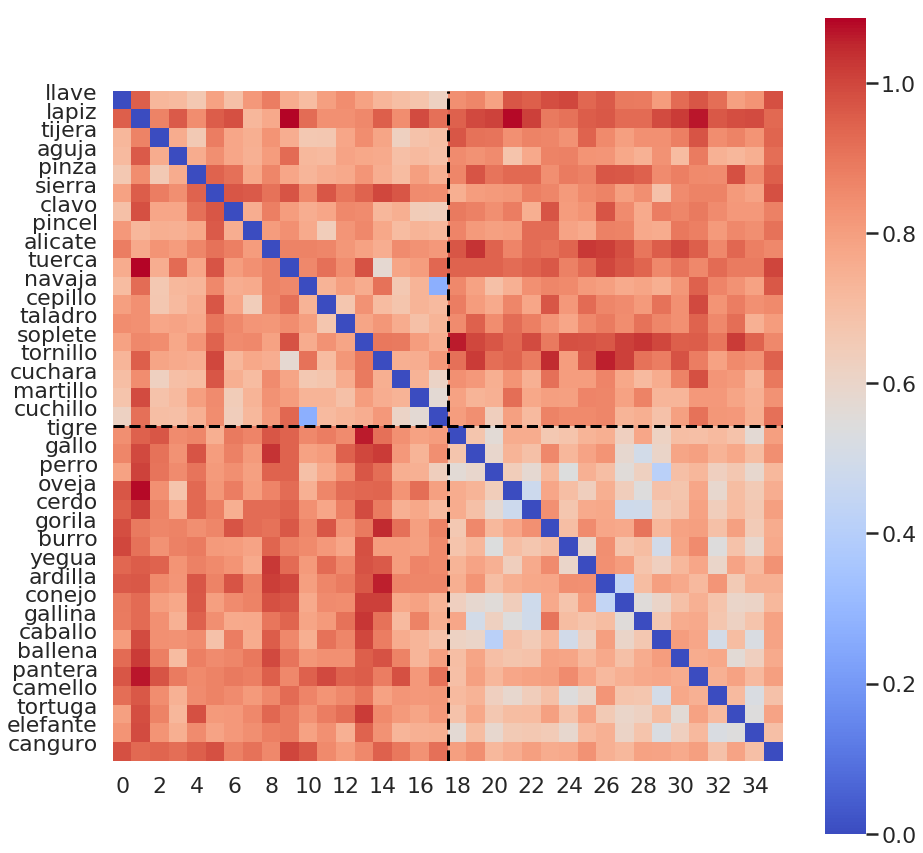

In [47]:
word2vec_features = np.array([model_glove[word] for word in words])
word2vec_features = word2vec_features - word2vec_features.mean(1)[:,np.newaxis]
RDM = distance.squareform(distance.pdist(word2vec_features,'cosine'))
fig,ax = plt.subplots(figsize=(15,15))

im = sns.heatmap(RDM,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.axhline(RDM.shape[0]/2,linestyle='--',color='black')
ax.axvline(RDM.shape[1]/2,linestyle='--',color='black')
_=ax.set(yticks=np.arange(36),yticklabels=words)

## Generated BOLD signals from words not used in the experiment

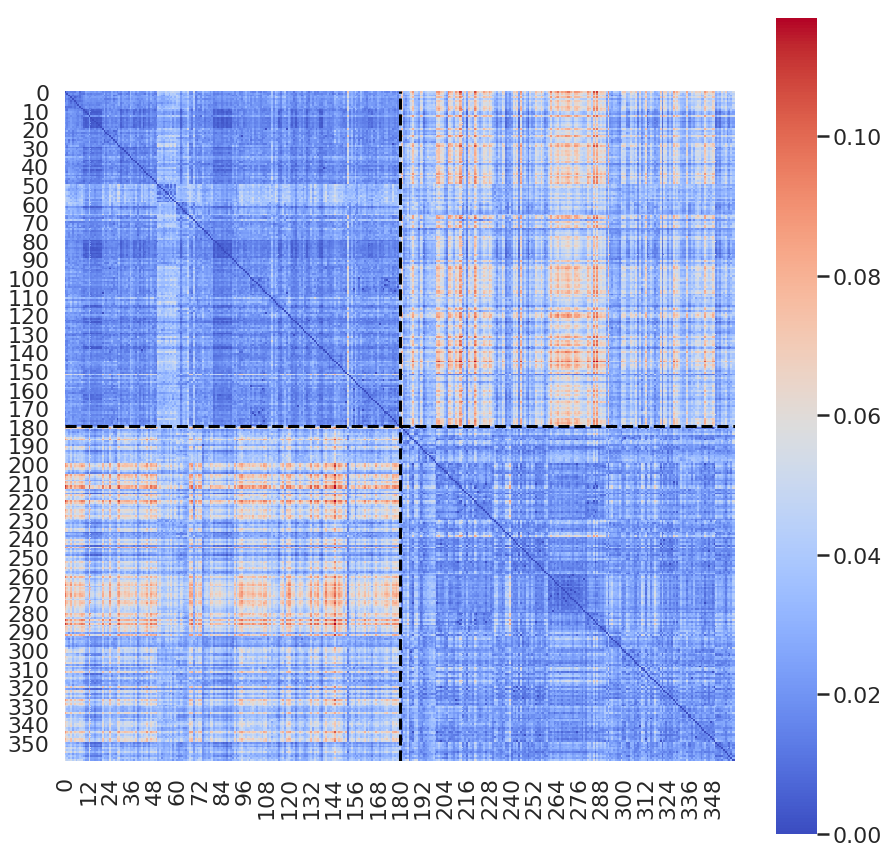

In [48]:
generated_BOLD = np.array([generator.predict(f.reshape(1,-1))[0] for f in features_st])
generated_BOLD = generated_BOLD - generated_BOLD.mean(1)[:,np.newaxis]
RDM = distance.squareform(distance.pdist(generated_BOLD,'cosine'))
fig,ax = plt.subplots(figsize=(15,15))

im = sns.heatmap(RDM,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.axhline(RDM.shape[0]/2,linestyle='--',color='black')
ax.axvline(RDM.shape[1]/2,linestyle='--',color='black')

## Generated BOLD signals from words used in the experiment

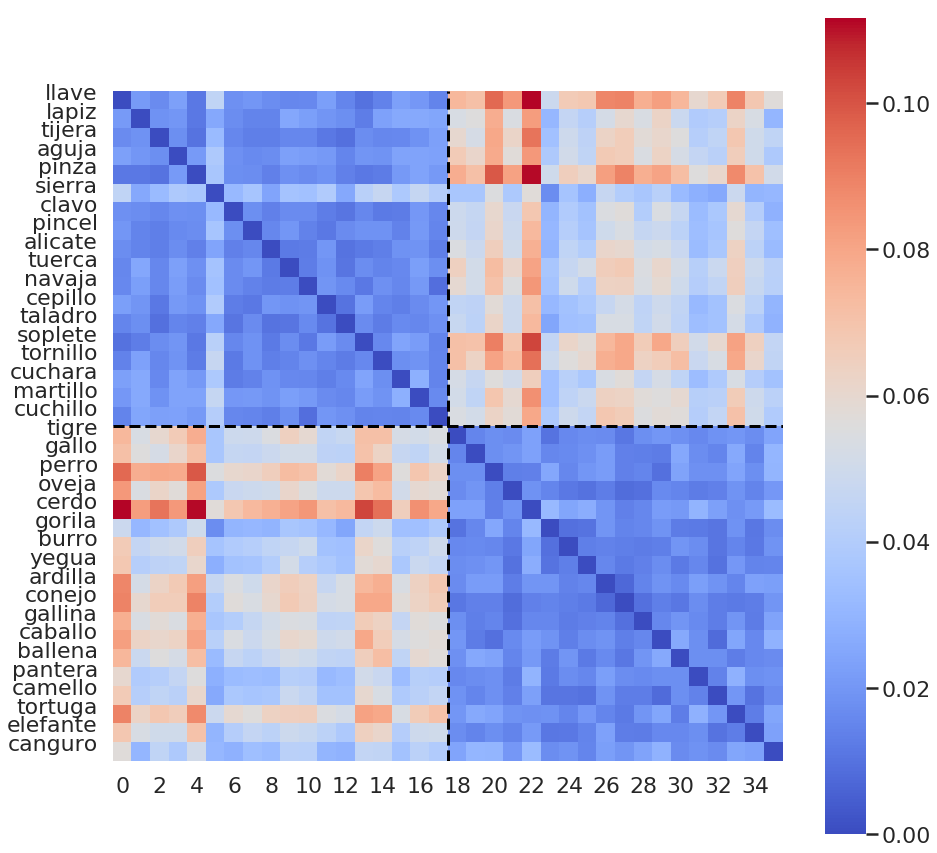

In [49]:
generated_BOLD = np.array([generator.predict(f.reshape(1,-1))[0] for f in features])    
generated_BOLD = generated_BOLD - generated_BOLD.mean(1)[:,np.newaxis]
RDM = distance.squareform(distance.pdist(generated_BOLD,'cosine'))
fig,ax = plt.subplots(figsize=(15,15))

im = sns.heatmap(RDM,
                 cmap = plt.cm.coolwarm,
                 square = True,
                 ax = ax)
ax.axhline(RDM.shape[0]/2,linestyle='--',color='black')
ax.axvline(RDM.shape[1]/2,linestyle='--',color='black')
_=ax.set(yticks=np.arange(36),yticklabels=words)